## Load the modules

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=20)   
plt.rc('ytick', labelsize=20)
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=25)

import numpy as np
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from pathlib import Path
import regions
from regions import CircleSkyRegion, PointSkyRegion

#import pickle
#import glob

## Load the gammapy modules

In [55]:
import gammapy
import gammapy.irf as irf
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation, Observations, DataStore
#from gammapy.utils.random import get_random_state
from gammapy.maps import MapAxis, WcsGeom, Map, RegionGeom
from gammapy.makers import SafeMaskMaker, MapDatasetMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, WobbleRegionsFinder
from gammapy.estimators import FluxPointsEstimator

# models modules
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    FoVBackgroundModel,
    SpectralModel,
    #Parameter, 
    TemplateSpectralModel
)
# dataset modules
from gammapy.datasets import (
    MapDataset, 
    MapDatasetOnOff, 
    MapDatasetEventSampler,
    SpectrumDatasetOnOff,
    SpectrumDataset, 
    Datasets,
    FluxPointsDataset
)

### Check the versions of the packages

In [44]:
print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)

gammapy: 0.20
numpy: 1.22.3
astropy 5.0.4
regions 0.6


## Load the DL3 data

In [125]:
datastore = DataStore.from_dir(f"../../arqus/data/crab_nebula/magic/")
obs_ids = [5029747, 5029748]

#NOT WORKING FOR THE CASE OF THE POINT-LIKE, GETTING AN ERROR WHEN CREATING THE DATASETS. 
#observations_crab = datastore.get_observations(obs_ids, required_irf='point-like')

# THIS IS A LIND FROM THE GAMMAPY NOTEBOOKS, THE DATA SEEMS TO BE THE SAME, BUT ALSO NOT WORKING, NO DATA LOADED
observations_crab = datastore.get_observations(
    required_irf=["aeff", "edisp", "rad_max"]
)

No HDU found matching: OBS_ID = 5029747, HDU_TYPE = rad_max, HDU_CLASS = None
Skipping run with missing HDUs; obs_id: 5029747
No HDU found matching: OBS_ID = 5029748, HDU_TYPE = rad_max, HDU_CLASS = None
Skipping run with missing HDUs; obs_id: 5029748


### Task 1: Print the observations

In [124]:
# %load ./Solutions/print_crab.py
print(observations_crab)


Observations
Number of observations: 0



### Task 2:  Check RA and DEC coordinates for Crab Nebula to define the region of interest (ROI)

In [50]:
# %load ./Solutions/coord.py
SkyCoord.from_name("Crab Nebula")


<SkyCoord (ICRS): (ra, dec) in deg
    (83.63308333, 22.0145)>

## Define the Circle sky region around our source

In [66]:
target_position = SkyCoord(ra=83.63, dec=22.0145, unit="deg", frame="icrs")

theta = observations_crab[0].aeff.meta['RAD_MAX']
assert all(o.aeff.meta['RAD_MAX'] == theta for o in observations_crab)

on_region_radius = Angle(theta*u.deg)
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

skydir = target_position.galactic

0.1414213


In order to take into account possible sources around the Crab Nebula, we need to create an exclusion mask.

### Task 3: Using the webpage http://gamma-sky.net/ find if there is a known gamma-ray source near Crab Nebula, and if there is one, its coordinates.

In [ ]:
# %load ./Solutions/exclusion_region.py
In the vicinity of  Crab Nebula, there is only one known gamma-ray source, the AGN called RGB J0521+212 with galactic coordinates GLON = 183.604 deg and GLAT = -8.708 deg.


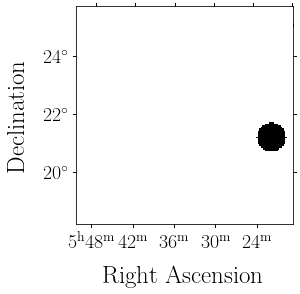

In [78]:
exclusion_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5* u.deg,
)
skydir = target_position.galactic
geom =  WcsGeom.create(
    npix=(150, 150), binsz=0.05, skydir=skydir, proj="TAN", frame="icrs"
)

exclusion_mask = ~geom.region_mask([exclusion_region])
exclusion_mask.plot();

### Create the Datasets - data reduction chain

In [102]:
energy_axis = MapAxis.from_energy_bounds(
    0.1, 40, nbin=10, per_decade=True, unit="TeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.05, 100, nbin=20, per_decade=True, unit="TeV", name="energy_true"
)

geom = RegionGeom.create(region=on_region, axes=[energy_axis])
dataset_empty = SpectrumDataset.create(
    energy_axis_true=energy_axis_true, geom=geom
)


In [108]:
dataset_maker = SpectrumDatasetMaker(
    containment_correction=True, selection=["counts", "exposure", "edisp"]
)
bkg_maker = ReflectedRegionsBackgroundMaker(exclusion_mask=exclusion_mask)

safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=5)

In [109]:
%%time
datasets = Datasets()

for obs_id, observation in zip(obs_ids, observations_crab):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), observation
    )
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

ValueError: Cannot apply containment correction for point-like IRF.

### We can see that the spectrum datasets contains all the ingredients for the likelihood calculation

In [ ]:
datasets[0].peek()

### Plot the off regions

In [ ]:
plt.figure(figsize=(8, 8))
ax = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)

## Define the spectral model and run the fit

In [ ]:
spectral_model = ExpCutoffPowerLawSpectralModel(
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    index=2,
    lambda_=0.1 * u.Unit("TeV-1"),
    reference=1 * u.TeV,
)
model = SkyModel(spectral_model=spectral_model, name="crab")

datasets.models = [model]

fit = Fit()
result = fit.run(datasets=datasets)

#### Plot the results and the parameters of the fit

In [ ]:
print(result)
datasets.models.to_parameters_table()
print(result.total_stat)

## Compute the flux points

We can compute flux points by fitting the norm of the global model in energy bands. We’ll use a fixed energy binning for now:

In [34]:
e_min, e_max = 0.7, 30
energy_edges = np.geomspace(e_min, e_max, 11) * u.TeV

In [ ]:
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab", selection_optional="all"
)
flux_points_crab = fpe.run(datasets=datasets)

Print the table of the resulting flux points: 

In [ ]:
flux_points.to_table(sed_type="dnde", formatted=True)

Plot the points:

In [35]:
plt.figure(figsize=(8, 5))
ax = flux_points.plot(sed_type="e2dnde", color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type="e2dnde")

NameError: name 'flux_points' is not defined

<Figure size 576x360 with 0 Axes>

Plot the resulting fit, together with the points: 

In [ ]:
flux_points_crab_dataset = FluxPointsDataset(
    data=flux_points_crab, models=datasets.models
)
flux_points_crab_dataset.plot_fit()

### Task 4: Define the Power law spectral model, using the PowerLawSpectralModel module with the default parameters, fit the dataset and print the results

In [ ]:
# %load ./Solutions/pwl_model.py
spectral_model_pwl = PowerLawSpectralModel(
)
model_pwl = SkyModel(spectral_model=spectral_model, name="crab_pwl")

datasets.models = [model_pwl]

fit = Fit()
result_pwl = fit.run(datasets=datasets)

datasets.models.to_parameters_table()
print(result_pwl)
print(result_pwl.total_stat)


### Task 5: Compute the flux points changing the energy range (100 GeV - 10 TeV) and number of bins (15).

In [ ]:
# %load ./Solutions/pwl_model_points.py
e_min, e_max = 0.1, 10
energy_edges = np.geomspace(e_min, e_max, 16) * u.TeV

fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab", selection_optional="all"
)
flux_points_crab_pwl = fpe.run(datasets=datasets)

flux_points_pwl.to_table(sed_type="dnde", formatted=True)

plt.figure(figsize=(8, 5))
ax = flux_points.plot(sed_type="e2dnde", color="darkorange")
flux_points_pwl.plot_ts_profiles(ax=ax, sed_type="e2dnde")


### Task 6: Plot the new pwl fit and the flux points.

In [ ]:
# %load ./Solutions/pwl_model_points_plot.py
flux_points_crab_dataset_pwl = FluxPointsDataset(
    data=flux_points_crab_pwl, models=datasets.models
)
flux_points_crab_dataset_pwl.plot_fit()
